# Biofysikk prosjekt

###### 31.01-14.02

I denne notebooken går vi gjennom hvordan membranløse organeller i cellekjernen tilordner seg i forhold til hverandre. Vi skal først se på disse som enkeltcellede organeller (monomerer). Vi modellerer dem med enten negativ eller positiv ladning, men lik i absoluttverdi. Vi skal så gå et steg videre og modellere disse organellene som polymerer, med flerverdighet L. Vi skal modellere dem slik at systemene vil oppnå så lav energi som mulig.

In [1]:
%matplotlib inline

import numpy as np
import time
import matplotlib.pyplot as plt
newparams = {'figure.figsize': (15.0, 7.5), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)

In [2]:
# Remove the # below to install numba if you do not have it already
#%pip install numba
from numba import jit
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

# Remove annoying deprecation warnings
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

## Oppgave 1a)

Først må vi ha en funksjon som lager systemet vi skal studere, nemlig en løsning med monomerer. Denne kaller vi grid_generator. Vi baserer den på verdiene $N$ og $M$, der $N$ er lengden og bredden på gitter (kalt grid gjennom notebooken) og $M$ er antall monomerer av en ladning. Vi får altså $2M$ monomerer. For at ikke plottet skal bli atlfor lite og gridet ikke altfor fullt/tomt, har vi satt dem til; $N = 15$, $M = 25$. Vi skal plassere disse monomerene tilfeldig, så da trenger vi en funksjon, random_position, som velger tilfeldige koordinater til å plassere monomerer.

In [3]:
ULTIMATE_TIME_START = time.time() ### Slettes

@jit(nopython=True) # Jitter funksjonen
def random_position(N):
    """
    random_position(N)
    Tar inn bredden og lengden til gridet.
    Returnerer et tilfeldig koordinat i gridet.
    """
    return np.random.randint(0, N), np.random.randint(0, N)


@jit(nopython=True) # Jitter funksjonen
def grid_generator(N,M):
    """
    grid_generator(N,M)
    parametere: N, Lengde og bredde av grid. 
                M, halvparten av antall monomerer.
    returnerer: Et grid med 2*M tilfeldige plasserte monomerer.
    """
    
    grid = np.zeros((N,N), dtype=np.dtype('i2')) # Lager en NxN array full av 0-er
    for i in range(2*M):                         # Iterer gjennom antall monomerer
        random_pos = random_position(N)          # Tar inn tilfeldig koordinat
        while grid[random_pos] != 0:             # Sjekker om det er en monomer der fra før
            random_pos = random_position(N)      # Plasserer monomer
        if i < M:                                # Fordeler negative og positive monomerer slik at
            grid[random_pos] = -1                # det er like mange av begge sorter.
        else:
            grid[random_pos] = 1
            
    return grid

## Oppgave 1b)

For å visualisere systemet vi skal modellere er det hensiktsmessig å lage et fargeplot. Det gjør vi med funksjonen, "plot_colormesh". Den bruker matplotlib sin pcolormesh-funksjon til å fargelegge gridet. Vi bruker også periodiske grensebetingelser, slik at venstre side har kontakt med høyre side og øverste linje har kontakt med den nederste.

Det er 50 ruter som ikke har verdi null


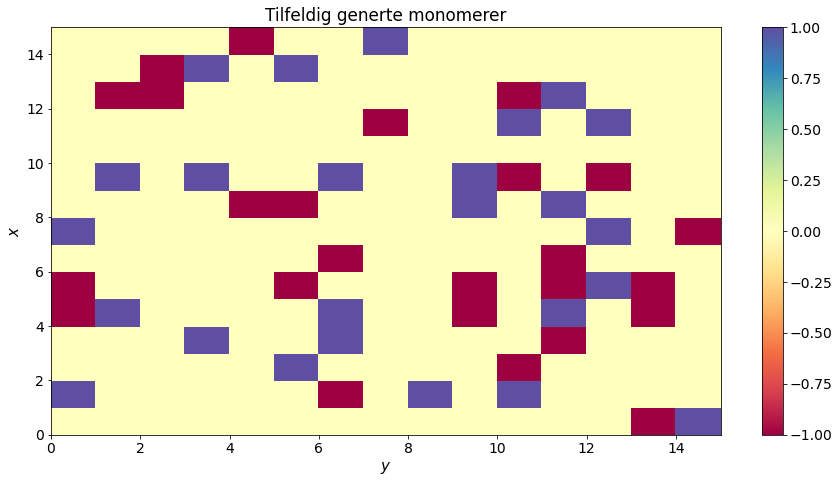

In [4]:
def plot_colormesh(grid, colors, N, title):
    """
    plot_colormesh(grid, colors)
    parametere: grid, monomerene/polymerene i løsningen.
                colors, hvilken farge plottet har.
    returnerer: ingenting, den plotter bare input-grid.
    """
    x, y = np.meshgrid(np.linspace(0, N, N+1),np.linspace(0, N, N+1))
    plt.title(title)
    plt.pcolormesh(x, y, grid[::-1], cmap = colors) # Plotter grid, bruker grid[::-1], 
    plt.colorbar()                                  # slik at [0,0] er oppe til venstre.
    plt.xlabel('$y$', fontsize = 15) #aksenavn
    plt.ylabel('$x$', fontsize = 15)
    plt.show()

N = 15  
M = 25
grid_1b = grid_generator(N, M)      # Lager løsning med monomerer
print(f'Det er {np.count_nonzero(grid_1b)} ruter som ikke har verdi null')
plot_colormesh(grid_1b, "Spectral", N, 'Tilfeldig generte monomerer') # Plotter gridet

Som vi kan se fra plottet, har vi valgt $N = 15$, og man kan telle opp $M = 50$ monomerer. De røde rektanglene er monomerene med negativ ladning, de blå rektanglene er monomerene med positiv ladning og det beige er den nøytrale løsninga monomerene befinner seg i.

## Oppgave 1c)

For å finne energien til gridet og vite om man kan flytte monomerer til siden eller opp og ned, må vi ha informasjon om nabocellene. Denne informasjonen finner vi med funksjonen "neighbor_locator". Den tar inn en celle og finner koordinatene til cellene til høyre og venstre for seg, og over og under seg.

In [5]:
@jit(nopython=True)
def neighbor_locator(grid, N, i, j):
    """
    neighbor_locator(grid, N, i, j)
    parametere: grid, monomerene/polymerene i løsningen.
                N, Lengden og bredden til grid. 
                i, x-koordinater i gridet.
                j, y-koordinater i gridet.
    returnerer: 4x3-array med koordinater og tilhørende verdi av cellen i (k, 2) der k går fra 0-3.
    """
    coordinates = np.zeros((4, 3), dtype=np.dtype('i2')) # Lager 4x3-array med 0-er
    if i == N-1:                                         # Sjekker om i går utenfor gridet
        coordinates[0] = [0, j, grid[0, j]]              # Finner verdi og koordinater til høyre for monomer
    else:                                                
        coordinates[0] = [i+1, j, grid[i+1, j]]      
    if i - 1 < 0:                                        # Sjekker om i går utenfor gridet
        coordinates[1] = [N-1, j, grid[N-1, j]]          # Finner verdi og koordinater til venstre for monomer
    else:
        coordinates[1] = [i-1, j, grid[i-1, j]]
    if j - 1 < 0:                                        # Sjekker om j går utenfor gridet
        coordinates[2] = [i, N-1, grid[i, N-1]]          # Finner verdi og koordinater over monomeren
    else: 
        coordinates[2] = [i, j-1, grid[i, j-1]]
    if j == N-1:                                         # Sjekker om j går utenfor gridet
        coordinates[3] = [i, 0, grid[i, 0]]              # Finner verdi og koordinater under monomeren
    else:
        coordinates[3] = [i, j+1, grid[i, j+1]]
    return coordinates                                   # Returnerer koordinatene med tilhørende verdi

## Oppgave 1d)

For å finne ut hvordan systemet tilordner seg slik at det har lavest energi, må vi også vite energien til systemet. Den finner vi med funksjonen "get_total_energy". Her er det også nødvendig å definere noen konstanter. Vi definerer da størrelsen til en monomer (og da størrelsen på en celle i gridet) som $a = (23\cdot10^{-6})^2$m. Energien mellom to monomerer er gitt ved:

$$
    \displaystyle V_{kl} = w_k w_l\frac{e^2}{4\pi\varepsilon_0\varepsilon_r a^2}\frac{a^2}{\boldsymbol{r}_k-\boldsymbol{r}_l} = w_k w_l\alpha \frac{a}{\boldsymbol{r}_k-\boldsymbol{r}_l}, \qquad \alpha = \frac{e^2}{4\pi\varepsilon_0\varepsilon_r a}
$$

Der $\varepsilon_0 = 8.8541878128\cdot10^{-12}$ Fm$^{-1}$, som er permittiviteten til elektriske felt i vakuum. $\varepsilon_r = 78$, som er den relative permittiviteten i vann. $e = 1.602 176 565\cdot10^{-19}$C, som er elementærladningen. $w_i = \{-1, 1\}$, som er fortegnet på ladningen til monomer $i$ og $\boldsymbol{r}_i$ er posisjonen til monomer $i$. 

Vi vil kun se på energien mellom to monomerer som er nærmeste naboer, og kan neglisjere resten av dem. Da kan vi regne ut energien mellom to monomerer som; 

\begin{equation}
    V_{kl} = 
    \begin{cases}
        w_k w_l\alpha, \quad \text{hvis } \boldsymbol{r}_k \text{ og } \boldsymbol{r}_l \text{ er nærmeste naboer,}\\
        0, \quad\quad\quad \text{ellers.}
    \end{cases}
\end{equation}

Så må vi summere over alle monomerene, men da teller vi opp dobbelt slik at vi kan dele på to for å få den faktiske totale energien til hele systemet.

In [6]:
relative_permittivity = 78
a = (23e-6)**2  #distance between grid points

@jit(nopython=True)
def get_total_energy(grid, N, relative_permittivity, a):
    """
    get_total_energy(grid)
    parametere: grid, monomerene/polymerene i løsningen.
                N,
                relative_permittivity, den relative permittiviteten for elektriske felt i løsningen.
                a, størrelsen på hver monomer.
    returnerer: den totale energien i løsningen.
    """
    energy_constant = 1.6e-19**2/(4*np.pi*8.85e-12*relative_permittivity*a) # \alpha, slik den er beskrevet over
    total_energy = 0                                              # Lager en variabel for energien
    for i in range(N):                                            # Itererer gjennom hele gridet
        for j in range(N):
            NN_coordinates = neighbor_locator(grid, N, i, j)      # Finner naboene, og verdiene
            charge = grid[i,j]                                    # Lagrer ladningen til cellen [i, j] i gridet
            monomer_energy = 0                                    # Startverdien er o
            for t in range(4):                                    # Itererer gjennom nabocellene
                monomer_energy += charge*NN_coordinates[t, 2]   # Finner den relative energien mellom to celler
            total_energy += monomer_energy
    return (total_energy / 2)*energy_constant                # Returnerer halvparten slik at man ikke teller 
                                                                  # monomerer samtidig.
    
grid_energy_1d = get_total_energy(grid_1b, N, relative_permittivity, a) # Regner ut energien til gridet.
print(f"Energien til gridet fra 1b) er: {np.round(grid_energy_1d, 22)} J")

Energien til gridet fra 1b) er: -1.67e-20 J


Denne energiverdien virker rimelig, når det regnes med såpass små organeller med ladninger av størrelsesorden elementærladningen.

## Oppgave 1e)

Vi skal her nå lage funksjonen som simulerer hvordan monomerene vil oppføre seg i forhold til hverandre over tid. Først trenger vi en funksjon som velger en tilfeldig monomer, "pick_random_monomer". I tillegg må vi kunne flytte på monomerene, slik at de kan tilordne seg med lavest energi, da har vi "move_monomer" til å gjøre det. For å bevare antallet monomerer, er det ikke lov å flytte en monomer på en annen, den må flytte inn i en ledig celle, og kun en av sine nærmeste naboer. Vi må også ta høyde for den termiske energien til hver monomer. Selv om den ikke får lavere energi ved å flytte på seg, kan monomerens termiske energi få den til å flytte på seg. Vi tar høyde for dette ved at hvis $e^{-\beta\Delta E} > p$ skal monomeren flytte på seg, uavhengig av $\Delta E$. $\beta = \frac1{k_bT}$ og $\Delta E = E_{etter} - E_{før}$, $p$ er et tilfeldig tall mellom $0$ og $1$.

Vi simulerer ved hjelp av Monte Carlo algoritmen. Den går ut på å kjøre simuleringa gjennom $N_s$ iterasjoner. For hver iterasjon velger vi en tilfeldig monomer, sjekker om den har ledige celler ved siden av seg den kan flytte til og så sjekker om den enten får lavere energi ved å flytte eller om den termiske energien flytter den. Dersom den har det velger vi en tilfeldig retning og flytter dit. Funksjonene "de_tupleize" og "beta" ble laget for å gjøre koden ryddigere. Førstnevnte henter ut et første- og andrekoordinatet fra en tuppel, mens "beta" gir ut konstanten $\beta$ slik den er definert over.

In [7]:
@jit(nopython=True)
def pick_random_monomer(grid): # Lager en funksjon som velger en tilfeldig monomer
    """
    pick_random_monomer(grid)
    parametere: grid, monomerene/polymerene i løsningen.
    returnerer: posisjonen til monomeren og dens verdi
    """
    random_pos = random_position(N)
    while grid[random_pos] == 0:              
        random_pos = random_position(N)       #finner nye tilfeldige koordinater om ladningen i punktet er lik 0
    return random_pos, grid[random_pos]


@jit(nopython=True)
def move_monomer(grid, moving_number): # Lager en funksjon for å kunne flytte monomerer
    """
    move_monomer(grid, moving_number)
    parametere: grid, monomerene/polymerene i løsningen.
                moving_number, et tilfeldig tall mellom 0 og 3, som sier retningen en monomer skal flytte i.
    returnerer: et oppdatert grid, hvor en monomer er flytta, hvis det var lov.
    """
    coordinates, charge = pick_random_monomer(grid) # Finner en tilfeldig monomer
    grid[coordinates] = 0                           # Fjerner monomeren
    NN_coordinates = neighbor_locator(grid, N, coordinates[0], coordinates[1])   #nabo-koordinater
    
    for k in range(4):                        # Iterer gjennom alle retningene
        
        if moving_number == 0:                # Sjekker om monomer skal til høyre
            if NN_coordinates[0,2] != 0:      # Sjekker om det er lov
                moving_number += 1            # Hvis ikke går vi til neste retning
                continue
            else:
                grid[NN_coordinates[0,0], NN_coordinates[0,1]] = charge # Flytter monomer 
                break

        if moving_number == 1:                # Sjekker om monomer skal til venstre
            if NN_coordinates[1,2] != 0:      # Sjekker om det er lov
                moving_number += 1            # Hvis ikke går vi til neste retning
                continue
            else:
                grid[NN_coordinates[1,0], NN_coordinates[1,1]] = charge # Flytter monomer 
                break

        if moving_number == 2:                # Sjekker om monomer skal opp
            if NN_coordinates[2,2] != 0:      # Sjekker om det er lov
                moving_number += 1            # Hvis ikke går vi til neste retning
                continue
            else:
                grid[NN_coordinates[2,0], NN_coordinates[2,1]] = charge # Flytter monomer 
                break

        if moving_number == 3:                # Sjekker om monomer skal ned
            if NN_coordinates[3,2] != 0:      # Sjekker om det er lov
                moving_number = 0             # Hvis ikke går vi til neste retning
                continue
            else:
                grid[NN_coordinates[3,0], NN_coordinates[3,1]] = charge # Flytter monomer 
                break
                
    return grid



@jit(nopython=True)
def de_tupleize(coordinates): # Lager en funksjon som gjør om en tuppel til to verdier
    """
    de_tupleize(coordinates)
    parametere: coordinates, koordinatene til en celle i gridet, type tuppel.
    returnerer: de samme koordinatene, men nå som to heltall i steden for en tuppel.
    """
    x_coordinate, y_coordinate = coordinates 
    return x_coordinate, y_coordinate

@jit(nopython=True)
def beta(T): # Lager en funksjon som regner ut beta
    return 1/(k_b*T)


@jit(nopython=True)
def MC_algorithm(M, N, N_s, T, grid):
    """
    MC_algorithm(M, N, N_s, T, grid)
    parametere: N, Lengden og bredden til grid. 
                M, halvparten av antall monomerer.
                N_s, antall iterasjoner.
                T, temperaturen i løsningen
                grid, monomerene/polymerene i løsningen.
    returnerer: Et oppdatert grid, med flyttede monomerer og energien til det oppdaterte gridet i elektronvolt.
    """
    
    energies = np.zeros(N_s, dtype=np.dtype('f4')) # Lager en tom array, for å lagre energiene 
    grid_energy = get_total_energy(grid, N, relative_permittivity, a) # Finner energien til den første tilstanden
    energies[0] = grid_energy                     
    
    for k in range(N_s): # Iterer gjennom Monte Carlo algoritmen
        grid_energy = get_total_energy(grid, N, relative_permittivity, a) # Finner energi
        monomer_coordinates, monomer_value = pick_random_monomer(grid) # Finner tilfeldig monomer
        x_coordinate, y_coordinate = de_tupleize(monomer_coordinates)  # gjør om koordinatene til verdier
        moving_number = np.random.randint(0,4)                         # Lager et tilfeldig tall for flytting
        new_grid = grid.copy()                                         # Lager ny grid, som kopi av det gamle
        new_grid = move_monomer(new_grid, moving_number).copy()        # Flytter en monomer i nytt grid
        new_grid_energy = get_total_energy(new_grid, N, relative_permittivity, a) # Finner energi i ny grid
        
        if new_grid_energy < grid_energy:  # Sjekker om energien har minket
            grid = new_grid.copy()         # Gjør nytt grid til hovedgrid
            grid_energy = new_grid_energy  # Lagrer energien
        elif np.random.random() < np.exp(-beta(T)*(new_grid_energy - grid_energy)): # Tar høyde for termisk energi
            grid = new_grid.copy()         # Gjør nytt grid til hovedgrid
            grid_energy = new_grid_energy      # Lagrer energien
            
        energies[k] = grid_energy    
    return grid, energies/1.6e-19       

## Oppgave 1 f)

For å se på forskjellene den termiske energien gir, simulerer vi nå systemet med monomerer ved $T = 200$K og $T = 500$K. Dette er ikke realistiske temperaturer for en cellekjerne og dens organeller, men som sagt får de ut betydningen til den termiske energien.

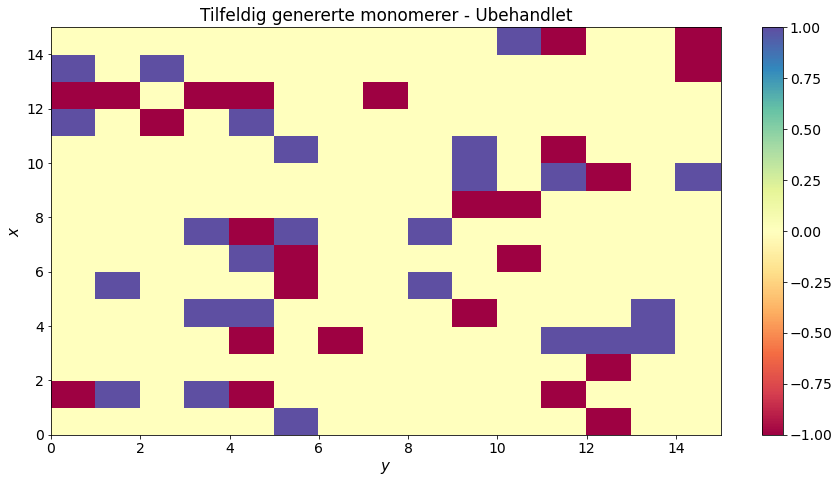

Startenergi: -3.9051e-20  J


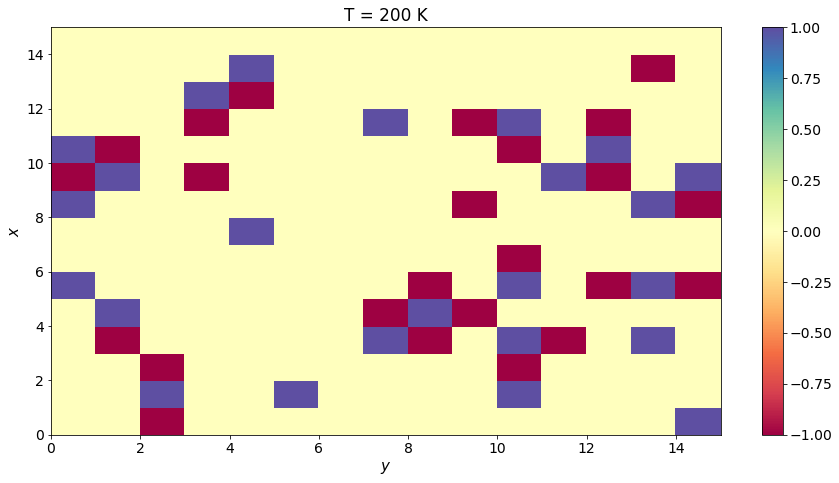

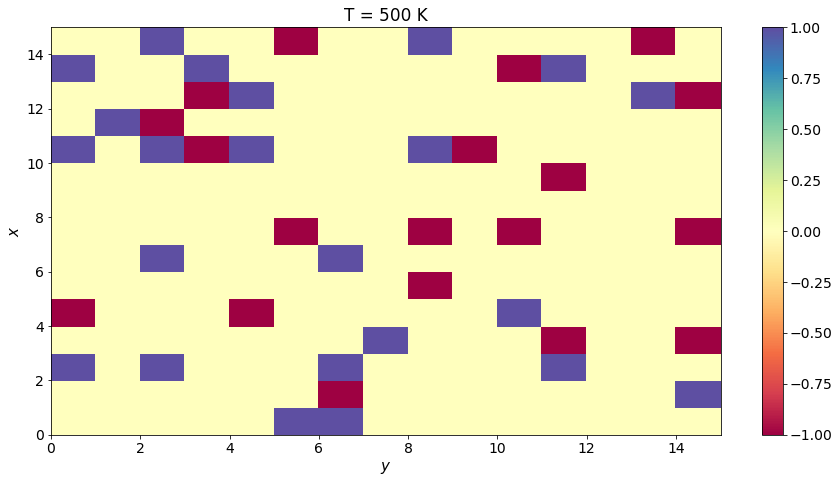

Sluttenergi 200K: -1.8409860418490572e-19 J
Sluttenergi 500K: -6.694494697632935e-20 J


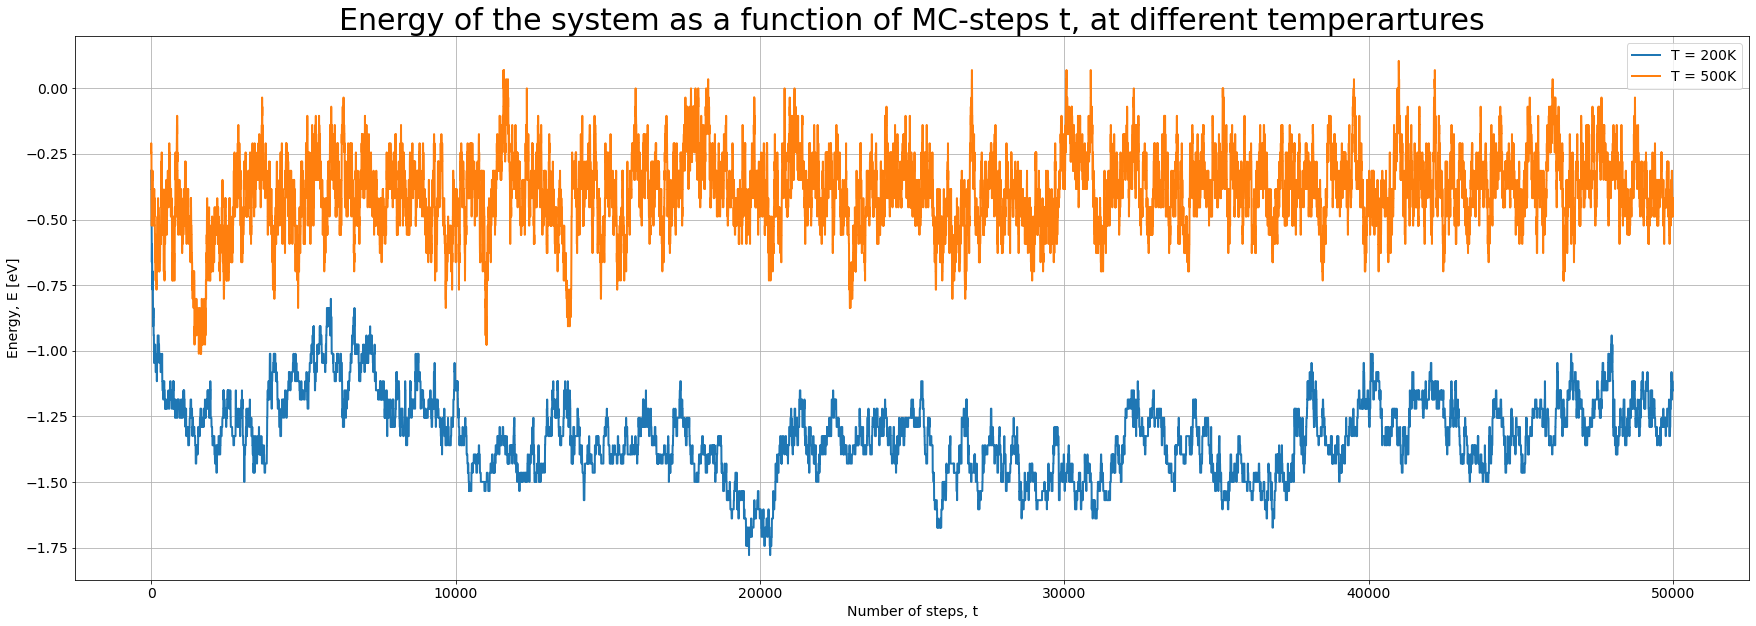

Koden brukte 96.0 sekund på å kjøre.


In [8]:
N = 15
M = 25
N_s = 50000
k_b = 1.38064852e-23 # J/K
T_low = 200 # K
T_high = 500 # K


time_start = time.time()                    # Lagrer en tidsverdi for å se hvor lang tid koden tar
grid_1f = grid_generator(N, M)              # Lager et grid
plot_colormesh(grid_1f, 'Spectral', N, 'Tilfeldig genererte monomerer - Ubehandlet')         # Plotter gridet
print(f'Startenergi: {np.round(get_total_energy(grid_1f, N, relative_permittivity, a), 24)}  J') # Finner energien til gridet 

grid_low_1f, energy_low_1f = MC_algorithm(M, N , N_s, T_low, grid_1f) # Kjører Monte Carlo ved lav temperatur
np.savez('Low_temperature_1f', grids = grid_low_1f, energies = energy_low_1f) # Lagrer grid og tilhørende energi
grid_high_1f, energy_high_1f = MC_algorithm(M, N , N_s, T_high, grid_1f) # Kjører Monte Carlo ved høy temperatur

plot_colormesh(grid_low_1f, 'Spectral', N, 'T = 200 K') # Plotter ved lav temperatur
plot_colormesh(grid_high_1f, 'Spectral', N, 'T = 500 K') # Plotter ved høy temperatur
print(f'Sluttenergi 200K: {(get_total_energy(grid_low_1f, N, relative_permittivity, a))} J') # Finner energien ved lav temperatur
print(f'Sluttenergi 500K: {(get_total_energy(grid_high_1f, N, relative_permittivity, a))} J') # Finner energien ved høy temperatur


t = np.linspace(0, N_s, len(energy_low_1f)) # Lager array med antall steg i Monte Carlo
plt.figure(figsize = (30,10)) 
plt.title('Energy of the system as a function of MC-steps t, at different temperartures', fontsize=30) 
plt.plot(t, energy_low_1f, label = "T = 200K") # Plotter energiutviklingen for lav temperatur
plt.plot(t, energy_high_1f, label = "T = 500K") # Plotter energiutviklingen for høy temperatur
plt.xlabel('Number of steps, t')
plt.ylabel('Energy, E [eV]')
plt.legend()
plt.show()

print(f"Koden brukte {np.round(time.time() - time_start, 1)} sekund på å kjøre.") # printer tiden koden brukte

Man kan se at ved lav temperatur har monomerene samla seg i klynger i større grad enn ved høy temperatur. Dette er å forvente siden sannsynligheten for at en monomer forflytter seg på grunn av sin termiske energi, $e^{-\beta\Delta E} \rightarrow 0$ når $T \rightarrow 0$. En kan også i stor grad se at de negative monomerene har positive monomerer som nærmeste naboer og omvendt. Dette er logisk fordi da får man negativt fortegn på monomerenes energi og da blir totalen lavere. For $T=500$K er dette mindre fremtredende. Dette skylder at høyere termisk energi øker sannsynligheten for forflytning i tilfeldig retning. Dermed vil klyngene være mindre. 

Ut fra energiplottet over, virker det henisktsmessig å velge $t=?$ for $T=200K$. Det er omtrent da energien når likevektsgrensen, slik at energien for større $t$ vil variere rundt denne verdien. Ved gjentatte kjøringer virker det som om $t \in [8 000,12 000]$ for denne temperaturen. Det er derimot ikke like lett å identifisere når systemet har nådd likevekt, da det for den lave temperaturen er større sannsynlighet at et lokalt energiminimum vil ligge tett opptil den globale minsteverdien. Dermed vil Monte Carlo-alogritmen kunne bli værende i et slikt bunnpunkt en god stund før den finner det faktiske minimumet, og med få tidssteg vil algoritmen kanskje ikke finne det.

Det ser imidlertid ut som om energien rundt $T=500$K er i likevekt ved start, da den høye termiske energien gjør alle bevegelsene tilfeldige, slik at flyttingen ikke nødvendigvis går mot lavere energi. Prosessen til sluttgitteret er dermed nesten nesten like tilfeldig som det å lage et nytt et. Dermed vil sluttenergien være variere innenfor det samme intervallet startverdiene varierer inni. 

## Oppgave 1g)

I denne oppgaven er målet å lage en funksjon som registrerer klynger av monomerer, såkalte "clusters". For å sjekke dette, undersøkes det om monomerer ligger inntil hverandre, ved hjelp av "neighbor_locator"-funksjonen fra oppgave 1c). Det benyttes også rekursjon for å hindre at allerede tildelte klynger ikke telles på nytt. Laget også en ny plotte-funksjon for å illustrere forskjellen mellom monomer-gitteret og klynge-gitteret.

In [9]:
@jit(nopython=True)
def cluster_recursion(grid, N, i, j, cluster_grid, cluster_counter):
    """
    cluster_recursion(grid, N, i, j, cluster_grid, cluster_counter)
    parametere: grid, monomerene/polymerene i løsningen.
                N, Lengden og bredden til grid.
                i, x-koordinater i gridet.
                j, y-koordinater i gridet.
                cluster_grid, polymerene i løsningen.
                cluster_counter, "Verdien" til hver klynge.
    returnerer: ingenting, siden den er rekursiv, vil den oppdateres uten returverdier.
    """
    cluster_grid[i,j] = cluster_counter # Legger en monomer i klynga og setter en verdi på den
    if grid[i,j] != 0 and cluster_grid[i,j] == cluster_counter: # Sjekker om en monomer er funnet 
        NN_coordinates = neighbor_locator(cluster_grid, N, i, j) # Finner naboene
        for k in range(4):                        # Itererer gjennom naboene
            if np.abs(i) >= N or np.abs(j) >= N:  # Stopper funksjonen mot å gå uendelig lenge
                continue
            if grid[NN_coordinates[k,0], NN_coordinates[k,1]] != 0 and cluster_grid[NN_coordinates[k,0], NN_coordinates[k,1]] == 0: # Sjekker om monomeren er i klynga
                cluster_recursion(grid, N, NN_coordinates[k,0], NN_coordinates[k,1], cluster_grid, cluster_counter) # Looper gjennom funksjonen til hele klynga er fnnet.
                 
    
@jit(nopython=True)
def cluster_grid_generator(grid, N):
    """
    cluster_grid_generator(grid, N)
    parametere: grid, monomerene/polymerene i løsningen.
                N, Lengden og bredden til grid.
    returnerer: et grid med klynger i steden for monomerer.
    """
    cluster_grid = np.zeros_like(grid, dtype=np.dtype('i2')) # Lager et tomt grid for klyngene
    cluster_counter = 1 # Setter en verdi på første klynga
    
    for i in range(N):  # Itererer gjennom hele gridet
        for j in range(N):
            if grid[i,j] != 0 and cluster_grid[i,j] == 0: # Sjekker om en ny monomer er funnet
                cluster_recursion(grid, N, i, j, cluster_grid, cluster_counter) # Lager en klynge
                cluster_counter += 1 # oppdaterer tallet slik at neste klynge får en ny verdi
    
    return cluster_grid
                                                                            
def plot_two_pcolormeshes(grid_1, grid_2, N, title_1, title_2, cmap_1, cmap_2):
    """
    plot_two_pcolormeshes(grid1, grid2, N)
    parametere: grid1, her; gridet med monomerer.
                grid2, her; gridet med klynger.
                N, Lengden og bredden til grid.
                title_1: Tittel til venstre subfigur 1
                title_2: Tittel til høyre subfigur 2
                cmap_1: Fargekombinasjonene til subfigur 1
                cmap_2: Fargekombinasjonene til subfigur 2
    returnerer: ingenting, den plotter de to gridene ved siden av hverandre.
    """
    x_1, y_1 = np.meshgrid(np.linspace(0, N, N+1), np.linspace(0, N, N+1)) # Lager koordinatssystem for gridene
    x_2, y_2 = np.meshgrid(np.linspace(0, N, N+1), np.linspace(0, N, N+1))
    fig, (ax_1, ax_2) = plt.subplots(1,2)
    ax_1.set_title(title_1)
    plot_1 = ax_1.pcolormesh(x_1, y_1, grid_1[::-1], cmap = cmap_1) # Plotter gridet med monomerer
    fig.colorbar(plot_1, ax = ax_1)
    ax_2.set_title(title_2)
    plot_2 = ax_2.pcolormesh(x_2, y_2, grid_2[::-1], cmap = cmap_2) # Plotter gridet med klynger
    fig.colorbar(plot_2, ax = ax_2)
    
    plt.xlabel('$y$', fontsize = 15) #aksenavn
    plt.ylabel('$x$', fontsize = 15)
    plt.show()

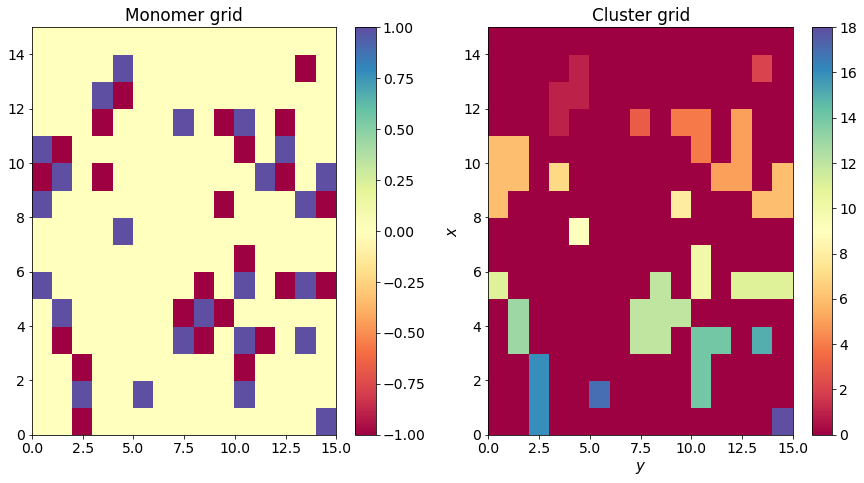

In [10]:
N = 15
M = 25

saved_file = np.load('Low_temperature_1f.npz')  #Henter grid-et for T=200K fra 1f)
monomer_grid_1g = saved_file['grids'] # Enten 'grids' eller 'energies' for å hente ut henholdsvis grid og energi
cluster_grid_1g = cluster_grid_generator(monomer_grid_1g, N) # Finner klyngene til gridet
plot_two_pcolormeshes(monomer_grid_1g, cluster_grid_1g, N, 'Monomer grid', 'Cluster grid','Spectral', 'Spectral') # Plotter monomerene og klyngene

Som en kan se, har hver klynge fått en egen verdi. 

## Oppgave 1h)

Nå skal vi modellere systemet i sin helhet. Spesielt skal vi se på hvordan gjennomsnittsstørrelsen, $\langle d\rangle$, på en klynge endres med temperaturen. Vi sjekker temperaturene $T = (100 +i100)$ K; der $i \in [0, 9] \in \mathbb{N} $. Vi må vente til systemet har nådd likevekt før vi måler størrelsen på klyngene. Dette skjer ved $$t_{equil} = t_{max}exp(-s(T-T_{lav})) + C,$$ $\ s = 1/200$, $t_{max} = 100 000$ og $C = 10 000$ er konstanter. 

In [11]:
@jit(nopython=True)
def t_equilibrium(t_max, s, T_array, C): # Finner punktet der systemet har nådd likevekt
    return t_max*np.exp(-s*(T_array - T_array[0])) + C

@jit(nopython=True)
def get_cluster_sizes(grid, N):
    """
    get_cluster_sizes(grid, N)
    parametere: grid, monomerene/polymerene i løsningen.
                N, Lengden og bredden til grid.
    returnerer: en array med størrelsene på klyngene.
    """
    cluster_grid = cluster_grid_generator(grid, N) # Finner et grid med klynger
    size_array = np.zeros(np.amax(cluster_grid) + 1, dtype=np.dtype('i2')) # Lager en array for å lagre størrelsene på klyngene
    
    for row in cluster_grid: # Itererer gjennom radene i gridet med klynger
        for element in row:  # Itererer gjennom hvert element i en rad
            size_array[element] += 1 # Legger til verdiene i arrayet for størrelser
            
    return size_array # Returnerer arrayet med størrelser


def mean_cluster_size(grid, N, t_array, T_array):
    """
    mean_cluster_size(grid, N, T_array)
    parametere: grid, monomerene/polymerene i løsningen.
                N, Lengden og bredden til grid.
                T_array, et array med temperaturer i kelvin.
    returnerer: en array med gjennomsnittelig størrelsene på klyngene.
    """
    cluster_sizes = get_cluster_sizes(grid, N) # Finner størrelsene på klyngene 
    mean_size_array = np.zeros(len(T_array), dtype = np.dtype('f4')) # Lager et array for å lagre de gjennomsnittelige størrelsene
    
    for i in range(len(T_array)): # Itererer gjennom alle temperaturene
        new_grid, energies = MC_algorithm(M, N, int(t_array[i] + n*t_r), T_array[i], grid) # Kjører grid gjennom Monte Carlo
        sizes = get_cluster_sizes(new_grid, N)  # Finner størrelsene til klyngene 
        mean_size_array[i] = np.mean(sizes[1:]) # Finner gjennomsnittet av størrelsene til klyngene og legger dem i et array
        
    return mean_size_array # Returnerer gjennomsnittsstørrelsene

In [12]:
N = 15  
M = 25
n = 10
T_low = 100 # Laveste temperatur, i kelvin
T_high = 1000 # Høyeste temperatur, i kelvin
T_array = np.linspace(T_low,T_high, n) # Lager et array med temperaturer
t_max = 1e4 # En konstant
t_r = 1e3
s = 1 / 200 # En konstant 
C = 1e4 # En konstant

time_start = time.time() # Starter tidtaking
t_array_1h = t_equilibrium(t_max, s, T_array, C) # Finner et array med likevektspunkt

mean_size_array_1f = mean_cluster_size(monomer_grid_1g, N, t_array_1h, T_array) # Fra 1f)

grid_1h = grid_generator(N,M)
mean_size_array_1h = mean_cluster_size(grid_1h, N, t_array_1h, T_array)

#np.savez('1h_Cluster', grid = grid_1h, size_array = mean_size_array) # Lagrer gridet

print(f'Time: {np.round(time.time()-time_start, 1)} s') # Sjekker tida

Time: 374.5 s


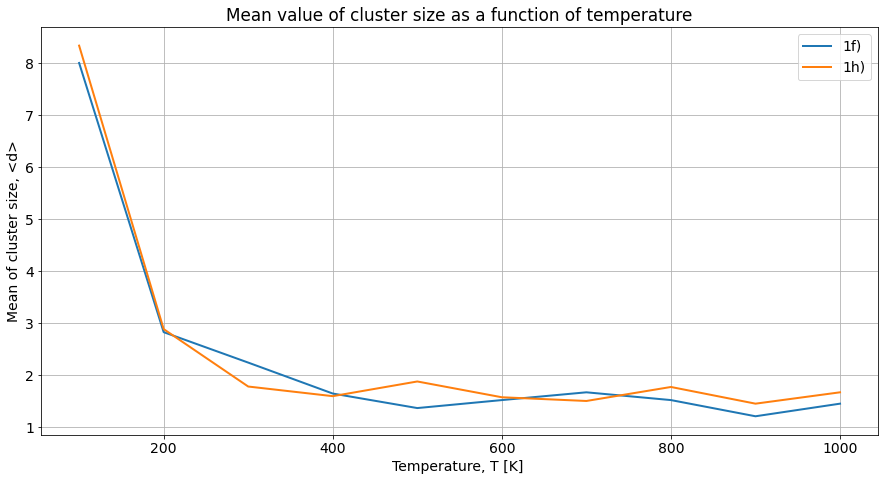

Time: 0.4 s


In [13]:
time_start = time.time() # Starter tidtaking


#cluster_file = np.load('1h_Cluster.npz')
#saved_size_array_1h = cluster_file['size_array']

# grid_1h2 = grid_generator(N,M)
# mean_size_array_1h2 = mean_cluster_size(grid_1h2, N, t_array_1h, T_array)

plt.title('Mean value of cluster size as a function of temperature') 
plt.plot(T_array, mean_size_array_1f, label='1f)')
plt.plot(T_array, mean_size_array_1h, label='1h)') # Plotter gjennomsnittsstørrelsene til klyngene som en funksjon av temperatur

plt.xlabel('Temperature, T [K] ');
plt.ylabel('Mean of cluster size, <d>');
plt.legend()
plt.show()

print(f'Time: {np.round(time.time()-time_start, 1)} s') # Sjekker tida

Som vi kan se minker $\langle d\rangle$ med økende temperatur. Dette er, som nevnt tidligere, på grunn av at $e^{-\beta\Delta E} \rightarrow 0$ når $T \rightarrow 0$. Vi kan se at når temperaturen er $400$K og høyere er den termiske energien såpass høy at den overstyrer monomerene sitt ønske om å ha lav energi. Det er ikke noe overraskende med det. Forskjellen er høyere ved lavere temperaturer da lav $T$ i mindre grad overskygger $\Delta E$ i eksponensialfunksjonen. Altså vil forskjellen i startenergi få større betydning enn ved høye temperaturer. Ved høyere temperatur vil dessuten monomerenes kinetiske energi oftere overstige energien i de kovalente bindingene mellom monomerene, slik at klyngene som dannes er mindre, men flere. Dette kan forklare nedgangen i $\langle d \rangle$ ved økende temperaturer. Ettersom det selv ved kun ti temperaturer en tydelig trend mellom forventet klyngestørrelse og temperatur, vil det tyde på at valget av $n$ er godt nok.  

## Oppgave 2a)

Nå skal vi fokusere på polymerer, altså sammensetning av monomerer. Vi gjør det samme som tidligere og lager en funksjon som returnerer et grid med polymerer. Dette gridet har også periodiske grensebetingelser. $M$ er antall polymerer av positiv eller negativ ladning, slik at vi har $2M$ polymerer. Det lille ekstra vi må tenke på er hvor store polymerene skal være. Størrelsen er gitt av $L$ og er flerverdigheten til polymerene, altså hvor mange monomerer den består av.

In [14]:
@jit(nopython=True)
def polymer_grid_generator(N, M, L):
    """
    polymer_grid_generator(N, M, L)
    parametere: N, Lengden og bredden til grid.
                M, halvparten av antall monomerer.
                L, multivalens til polymerene.
    returnerer: et grid med 2*M tilfeldige utplasserte polymerer.
    """
    polymer_grid = np.zeros((N, N), dtype=np.dtype('i2'))

    for i in range(-M, M + 1):
        if i == 0:
            continue
        random_pos = random_position(N)  # Tar inn tilfeldig koordinat

        while polymer_grid[random_pos] != 0:  # Sjekker om det er et polymer der fra før
            random_pos = random_position(N)   # Finner i så fall et nytt koordinat
        polymer_grid[random_pos] = i          # Lager en monomer      
        monomer_positions_array = np.zeros((L, 2), dtype=np.dtype('i2'))  #array for polymerets koordinater
        monomer_positions_array[0] = random_pos    

        for j in range(1, L):
            random_number = np.random.randint(0, len(monomer_positions_array))  #Tilfeldig tall mindre enn L
            random_monomer_pos = monomer_positions_array[random_number]   #Tilfeldig monomer
            x_coordinate, y_coordinate = de_tupleize(random_monomer_pos)
            NN_coordinates = neighbor_locator(polymer_grid, N, x_coordinate, y_coordinate)  #Finner naboene
            while polymer_grid[x_coordinate, y_coordinate] == 0 or np.count_nonzero((NN_coordinates[:, 2])) == 4:
                random_number = np.random.randint(0, len(monomer_positions_array))  # Hvis ingen monomer eller for mange naboer
                random_monomer_pos = monomer_positions_array[random_number]         # Finner nytt monomer
                x_coordinate, y_coordinate = de_tupleize(random_monomer_pos)
                NN_coordinates = neighbor_locator(polymer_grid, N, x_coordinate, y_coordinate)

            random_number = np.random.randint(0, 4)
            random_neighbor = NN_coordinates[random_number]
            while random_neighbor[2] != 0:   #sjekker naboene er ledige

                random_number = np.random.randint(0, 4)
                random_neighbor = NN_coordinates[random_number]
            polymer_grid[random_neighbor[0], random_neighbor[1]] = i  #Tegner en monomer i polymeret
            monomer_positions_array[j] = random_neighbor[:2]    #Legger denne til i polymer_koordinat_arrayen
    return polymer_grid


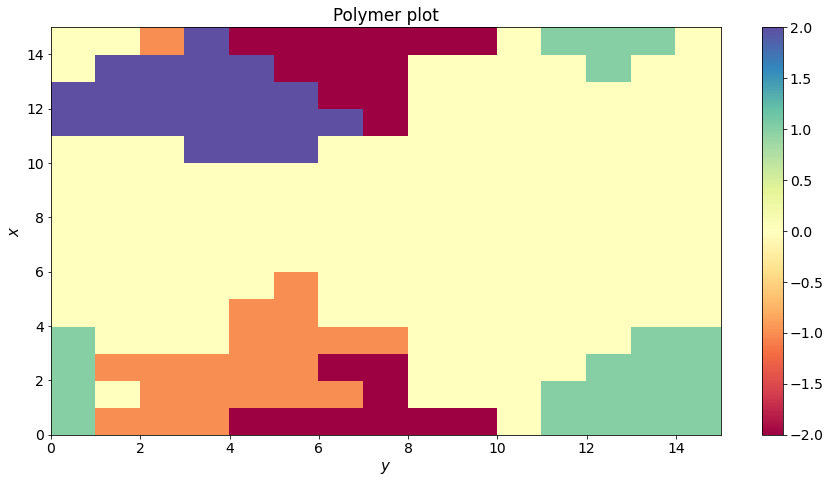

Time: 5.0 s


In [15]:
a = (91e-6)**2 # Størrelse på en celle i gridet
L = 21
N = 15
M = 2

time_start = time.time() # Starter tidtaking

polymer_grid_2a = polymer_grid_generator(N, M, L)
plot_colormesh(polymer_grid_2a, "Spectral", N, 'Polymer plot')

print(f'Time: {np.round(time.time()-time_start, 1)} s') # Sjekker tida

Her har vi plottet polymerene med $N = 15$, $L = 21$ og $M = 2$. Som betyr at vi har 4 monomerer med $21$ celler, på verdiene $\{-2, -1, 1, 2\}$.

## Oppgave 2 b)

For å kunne simulere systemets oppførsel over tid, må vi også her vite energien. Vi må da lage en ny funksjon for polymerene, "get_total_energy_polymer_system". Vi gjør en forenkling slik at vi kun ser på energien mellom polymerene, og ser bort i fra interaksjonene mellom monomerene i en polymer.

In [16]:
@jit(nopython=True)
def get_total_energy_polymer_system(polymer_grid, N, L, relative_permittivity, a):
    """
    get_total_energy(grid)
    parametere: grid, monomerene/polymerene i løsningen.
                N, bredden og lengden på gitteret
                relative_permittivity, den relative permittiviteten for elektriske felt i løsningen.
                a, størrelsen på hver monomer.
    returnerer: den totale energien i løsningen.
    """
    energy_constant = 1.6e-19**2/(4*np.pi*8.85e-12*relative_permittivity*a) # \alpha, slik den er beskrevet over
    total_energy = 0                                              # Lager en variabel for energien
    for i in range(N):                                            # Itererer gjennom hele gridet
        for j in range(N):
            NN_coordinates = neighbor_locator(polymer_grid, N, i, j)      # Finner naboene, og verdiene
            charge = polymer_grid[i,j]                                    # Lagrer ladningen til cellen [i, j] i gridet
            monomer_energy = 0                                    # Startverdien er o
            for t in range(4):     # Itererer gjennom nabocellene
                if NN_coordinates[t, 2] != charge and NN_coordinates[t,2] != 0 and charge != 0:
                    if charge / NN_coordinates[t, 2] < 0:
                        monomer_energy -= L #totalladningen
                    else:
                        monomer_energy += L   
            total_energy += monomer_energy   # Finner den relative energien mellom to celler
    return (total_energy / 2)*energy_constant                # Returnerer halvparten slik at man ikke teller 
                                                                  # monomerer samtidig.
    
polymer_grid_energy_2b = get_total_energy_polymer_system(polymer_grid_2a, N, L, relative_permittivity, a) # Regner ut energien til gridet.
print(f"Energien til det usorterte gridet er: {np.round(polymer_grid_energy_2b, 23)} J")


Energien til det usorterte gridet er: -2.2450000000000002e-20 J


## Oppgave 2 c)

Vi trenger en funksjon som flytter på polymerene, funksjonen vi har lagd under tillater ikke deformasjon av polymerer eller at de overlapper.

In [1]:
def rigid_move_polymer(polymer_grid, N, M, polymer_value, direction):
    polymer_grid = polymer_grid.copy()
    x_coordinates, y_coordinates = np.where(polymer_grid == polymer_value) # Finner polymeren med verdi polymer_value
    new_x_coordinates = np.zeros(len(x_coordinates),  dtype=np.dtype('i2'))
    new_y_coordinates = np.zeros(len(y_coordinates), dtype=np.dtype('i2'))
    moving_array = np.ones(len(x_coordinates), dtype=np.dtype('i2')) # Lager en array for å flytte polymeren
    
    if direction == 0: # Sjekker om den skal til høyre
        new_y_coordinates += (y_coordinates + moving_array) # Flytter polymeren
        for i in range(len(new_y_coordinates)): # Sjekker grensebetingelsene
            if new_y_coordinates[i] == -1:
                new_y_coordinates[i] = N - 1
            elif new_y_coordinates[i] == N:
                new_y_coordinates[i] = 0
        new_x_coordinates = x_coordinates.copy()
        
    elif direction == 1: # Sjekker om den skal til venstre
        new_y_coordinates += (y_coordinates - moving_array) # Flytter polymeren
        for i in range(len(new_y_coordinates)): # Sjekker grensebetingelsene
            if new_y_coordinates[i] == -1:
                new_y_coordinates[i] = N-1
            elif new_y_coordinates[i] == N:
                new_y_coordinates[i] = 0
        new_x_coordinates = x_coordinates.copy()
        
    elif direction == 2: # Sjekker om den skal opp
        new_x_coordinates += (x_coordinates - moving_array) # Flytter polymeren
        for i in range(len(new_x_coordinates)): # Sjekker grensebetingelsene
            if new_x_coordinates[i] == -1:
                new_x_coordinates[i] = N - 1
            elif new_x_coordinates[i] == N:
                new_x_coordinates[i] = 0
        new_y_coordinates = y_coordinates.copy()
        
    elif direction == 3: # Sjekker om den skal ned
        new_x_coordinates += (x_coordinates + moving_array) # Flytter polymeren
        for i in range(len(new_x_coordinates)): # Sjekker grensebetingelsene
            if new_x_coordinates[i] == -1:
                new_x_coordinates[i] = N - 1
            elif new_x_coordinates[i] == N:
                new_x_coordinates[i] = 0
        new_y_coordinates = y_coordinates.copy()
        
    else: # Hvis ikke, returnerer den gammelt grid
        return polymer_grid
    
    for j in range(len(x_coordinates)): # Iterer gjennom polymeren og sjekker om den kan flyttes
        if polymer_grid[new_x_coordinates[j], new_y_coordinates[j]] != 0 and polymer_grid[new_x_coordinates[j], new_y_coordinates[j]] != polymer_value:
            return polymer_grid # Hvis den ikke kan flyttes, returneres gammelt grid
        
    polymer_grid[x_coordinates,y_coordinates] = 0 # Setter verdiene til der polymeren flytta fra til 0
    polymer_grid[new_x_coordinates, new_y_coordinates] = polymer_value 
    return polymer_grid

## Oppgave 2d)

Nå skal vi skrive Monte Carlo algoritmen på nytt, denne gangen for polymerer. Den har de samme betingelsene for flytting som hos monomerer, altså at $e^{-\beta\Delta E} > p$ eller $\Delta E < 0$, der $p$ er et tilfeldig tall mellom $0$ og $1$.

In [18]:
def MC_algorithm_polymers(M, N, L, N_s, T, polymer_grid, move_func):
    """
    MC_algorithm_polymers(M, N, L, N_s, T, grid)
    parametere: N, Lengden og bredden til grid. 
                M, halvparten av antall monomerer.
                L, multivansitet til polymerer.
                N_s, antall iterasjoner.
                T, temperaturen i løsningen
                polymer_grid, polymerene i løsningen.
                move_func, en funksjon som flytter polymerer, enten rigid eller medium-fleksibelt.
    returnerer: Et oppdatert grid, med flyttede polymerer og energien til det oppdaterte gridet i elektronvolt.
    """
    
    energies = np.zeros(N_s, dtype=np.dtype('f4')) # Lager en tom array, for å lagre energiene 
    polymer_grid_energy = get_total_energy_polymer_system(polymer_grid, N, L, relative_permittivity, a) # Finner energien til den første tilstanden
    energies[0] = polymer_grid_energy
    
    for k in range(N_s): # Iterer gjennom Monte Carlo algoritmen
        random_polymer_value = np.random.randint(-M, M+1) # Tilfeldig polymer
        polymer_grid_energy = get_total_energy_polymer_system(polymer_grid, N, L, relative_permittivity, a) # Finner energi
        #polymer_coordinates, monomer_value = pick_random_monomer(grid) # Finner tilfeldig monomer
        #x_coordinate, y_coordinate = de_tupleize(monomer_coordinates)  # gjør om koordinatene til verdier
        moving_number = np.random.randint(0,4)                         # Lager et tilfeldig tall for flytting
#         moved_polymer_grid = move_func(polymer_grid, N, M, random_polymer_value, moving_number)
        new_polymer_grid = polymer_grid.copy()                                         # Lager ny grid, som kopi av det gamle
        new_polymer_grid = move_func(polymer_grid, N, M, random_polymer_value, moving_number) # Flytter en monomer i nytt grid
        new_polymer_grid_energy = get_total_energy_polymer_system(new_polymer_grid, N, L, relative_permittivity, a) # Finner energi i ny grid
        
        if new_polymer_grid_energy < polymer_grid_energy:  # Sjekker om energien har minket
            polymer_grid = new_polymer_grid.copy()         # Gjør nytt grid til hovedgrid
            polymer_grid_energy = new_polymer_grid_energy  # Lagrer energien
        elif np.random.random() < np.exp(-beta(T)*(new_polymer_grid_energy - polymer_grid_energy)): # Tar høyde for termisk energi
            polymer_grid = new_polymer_grid.copy()         # Gjør nytt grid til hovedgrid
            polymer_grid_energy = new_polymer_grid_energy      # Lagrer energien
            
        energies[k] = polymer_grid_energy    
    return polymer_grid, energies/1.6e-19

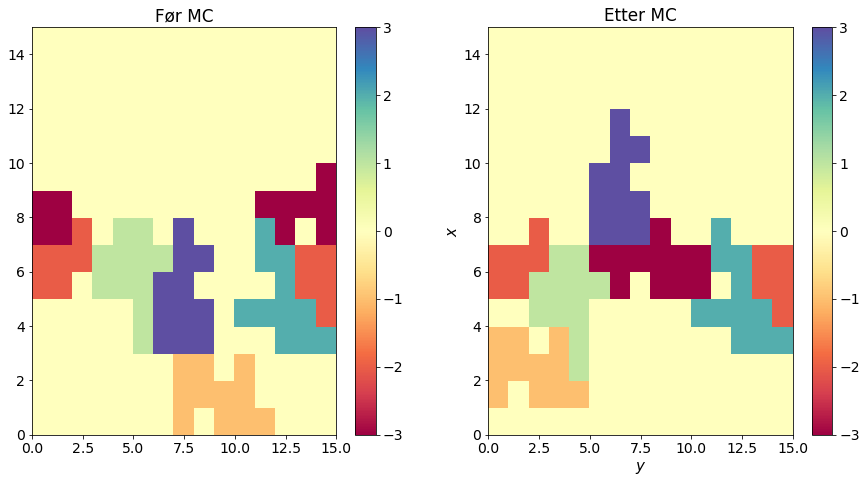

Koden brukte 57.7 sekund på å kjøre.


In [19]:
L = 11
M = 3
T = 200 
N = 15
N_s = 30000

polymer_grid_2d = polymer_grid_generator(N, M, L)

time_start = time.time()
polymer_grid_2d_rigid, polymer_energies_2d_rigid = MC_algorithm_polymers(M, N, L, N_s, T, polymer_grid_2d, rigid_move_polymer)
plot_two_pcolormeshes(polymer_grid_2d, polymer_grid_2d_rigid, N, 'Før MC', 'Etter MC','Spectral', 'Spectral')

print(f"Koden brukte {np.round(time.time() - time_start, 1)} sekund på å kjøre.") # printer tiden koden brukte

Energien ved start: -7.840290072209657e-21. Energien etter MC: -8.624318837092553e-20


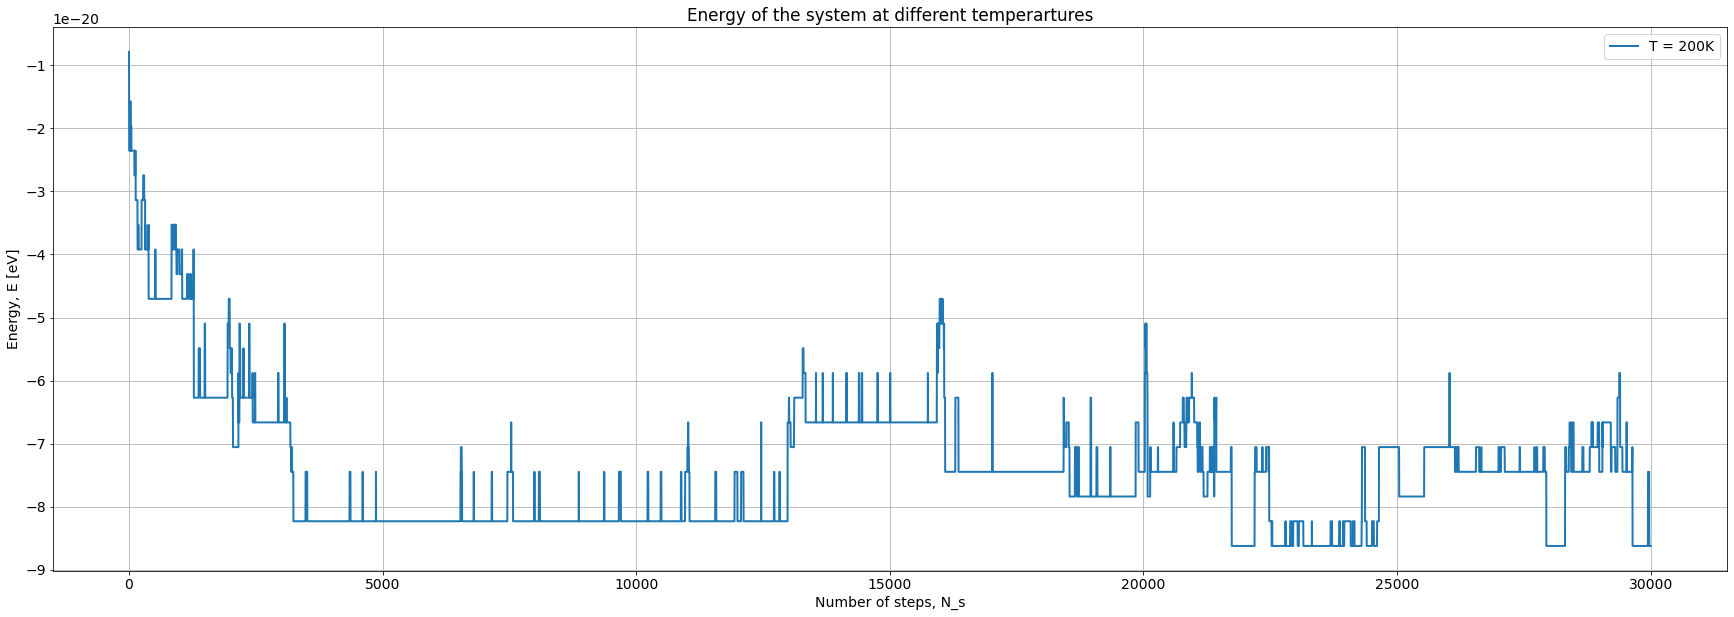

In [20]:
print(f'Energien ved start: {polymer_energies_2d_rigid[0]}. Energien etter MC: {polymer_energies_2d_rigid[-1]}')
t = np.linspace(0, N_s, len(polymer_energies_2d_rigid)) # Lager array med antall steg i Monte Carlo
plt.figure(figsize = (30,10)) 
plt.title('Energy of the system at different temperartures') 
plt.plot(t, polymer_energies_2d_rigid, label = "T = 200K") # Plotter energiutviklingen for lav temperatur
plt.xlabel('Number of steps, N_s')
plt.ylabel('Energy, E [eV]')
plt.legend()
plt.show()

Siden vi ikke tillater deformasjon i "rigid_move_polymer", ser vi at formene på polymerene ikke endrer seg med iterasjonene. Siden polymerene tar stor plass gir dette at det er få muligheter for bevegelse for dem, som er grunnen til at energien ikke går noe særlig ned. De har rett og slett ikke stor nok plass til å tilordne seg med lav energi. Kjøretiden her er kortere fordi det er færre tillate flyttinger, som gir færre oppdateringer av gridet. Det er i snitt færre ruter i gitteret som må sjekkes enn ved monomerene.

## Oppgave 2 e) og f)

Siden den forrige funksjonen for flytting ikke tillater deformasjon, skriver vi nå en funksjon som delvis tillater det. Det vil si at hvis en rad eller kolonne kræsjer i en nabopolymer, skal de stå stille, mens resten av polymeren flytter seg. I tillegg vil vi sjekke om vi bryter en polymer, dette gjør vi med "check_if_polymer_broken" som benytter "polymer_recursion" for å iterere gjennom klyngene. Da går vi bare tilbake til det gamle gridet, slik at vi ikke ender opp med mange små polymerer.

In [21]:
@jit(nopython=True)
def polymer_recursion(polymer_grid, N, i, j, cluster_grid, cluster_counter, k):
    """
    polymer_recursion(grid, N, i, j, cluster_grid, cluster_counter)
    parametere: polymer_grid, monomerene/polymerene i løsningen.
                N, Lengden og bredden til grid.
                i, x-koordinater i gridet.
                j, y-koordinater i gridet.
                cluster_grid, polymerene i løsningen.
                cluster_counter, "Verdien" til hver klynge.
    returnerer: ingenting, siden den er rekursiv, vil den oppdateres uten returverdier.
    """
    if polymer_grid[i, j] == k:
        cluster_grid[i, j] = cluster_counter
        NN_coordinates = neighbor_locator(polymer_grid, N, i, j) # Finner naboene
        for n in range(4):                        # Itererer gjennom naboene
            if np.abs(i) >= N or np.abs(j) >= N:  # Stopper funksjonen fra å gå uendelig lenge
                continue
            if polymer_grid[NN_coordinates[n,0], NN_coordinates[n,1]] == k and cluster_grid[NN_coordinates[n,0], NN_coordinates[n,1]] == 0: # Sjekker om monomeren er i klynga
                polymer_recursion(polymer_grid, N, NN_coordinates[n,0], NN_coordinates[n,1], cluster_grid, cluster_counter, k) # Looper gjennom funksjonen til hele klynga er funnet.
                

@jit(nopython=True)
def check_if_polymer_broken(polymer_grid, N, M):
    """
    cluster_grid_generator(grid, N)
    parametere: grid, monomerene/polymerene i løsningen.
                N, Lengden og bredden til grid.
                M, halvparten av antall polymerer.
    returnerer: et grid med klynger i steden for monomerer.
    """
    cluster_grid = np.zeros_like(polymer_grid, dtype=np.dtype('i2')) # Lager et tomt grid for klyngene
    cluster_counter = 1 # Setter en verdi på første klynga
    
    for i in range(N):  # Itererer gjennom hele gridet
        for j in range(N):
            for k in range(-M, M+1):
                if k == 0:
                    continue
                if polymer_grid[i, j] == k and cluster_grid[i, j] == 0: # Sjekker om en ny polymer er funnet
                    polymer_recursion(polymer_grid, N, i, j, cluster_grid, cluster_counter, k) # Lager en klynge
                    cluster_counter += 1 # oppdaterer tallet slik at neste klynge får en ny verdi
    
    if cluster_counter > 2*M + 1:  #En polymer har blitt oppbrutt
        return True                
    
    return False                   #Ingen polymerer har blitt oppbrutt
    
    

In [22]:
def medium_flexiblility_move(polymer_grid, N, M, polymer_value, direction):
    
    new_polymer_grid = polymer_grid.copy()
    
    not_moveable_rows = np.array([], dtype=int)  #Lager en array med rader der evetnuelt det foregår kollisjon mellom polymerer
    not_moveable_columns = np.array([], dtype=int) #Lager en array med rader der evetnuelt det foregår kollisjon mellom polymerer
    
    coordinates = np.argwhere(new_polymer_grid == polymer_value)  #henter ut polymerets koordinater                      
    
    for element in coordinates:
        new_polymer_grid[tuple(element)] = 0    #Fjerner polymeren
        NN_coordinates = neighbor_locator(new_polymer_grid,  N, element[0], element[1])  #Finner naboene
        if NN_coordinates[direction, 2] != polymer_value and NN_coordinates[direction, 2] != 0:  #Sjekker etter andre polymerer
            if direction == 0 or direction == 1:    #Hvis bevegelse opp eller ned
                not_moveable_columns = np.append(not_moveable_columns, element[1])   #Lagerer kolonner med kollisjon

            else:                                   #Hvis begevelse til høyre eller venstre
                not_moveable_rows = np.append(not_moveable_rows, element[0])         #Lagerer rader med kollisjon
    
    if direction == 0 or direction == 1:    
        if direction == 0:            #Hvis bevegelse ned
            coordinates += np.full_like(coordinates, (1,0))  #Flytter koordinatene ned
        else:                         #Hvis bevegelse opp 
            coordinates -= np.full_like(coordinates, (1,0))  #Flytter koordinatene opp
        for i in range(len(coordinates)):    #Tar hensyn til periodiske grensebetingelser
            if coordinates[i][0] == N:
                coordinates[i][0] = 0
                
            if coordinates[i][0] == -1:
                coordinates[i][0] = N-1 
                
        for element in coordinates:
            new_polymer_grid[tuple(element)] = polymer_value   #Tegner inn den flyttede polymeren
            
        if len(not_moveable_columns) > 0: 
            new_polymer_grid[:, not_moveable_columns] = polymer_grid[:, not_moveable_columns]  #Endrer ikke kolonner med kollisjon
    else:
        if direction == 2:    #Hvis bevegelse til venstre
            coordinates -= np.full_like(coordinates, (0,1))
        else:                 #Hvis bevegelse til høyre
            coordinates += np.full_like(coordinates, (0,1))
        for i in range(len(coordinates)): #Tar hensyn til periodiske grensebetingelser
            if coordinates[i][1] == N:
                coordinates[i][1] = 0
                
            if coordinates[i][1] == -1:
                coordinates[i][1] = N-1
                
        for element in coordinates:
            new_polymer_grid[tuple(element)] = polymer_value   #Tegner inn den flyttede polymeren
        if len(not_moveable_rows) > 0: 
            new_polymer_grid[not_moveable_rows,:] = polymer_grid[not_moveable_rows,:]  #endrer ikke på rader med kollisjon
                
    if check_if_polymer_broken(new_polymer_grid, N, M):   #Hvis oppbrutt returneres det gamle gridet
        return polymer_grid
    
    return new_polymer_grid    #nytt grid returneres

## Oppgave 2g)

Nå gjør vi samme simulering som i 2d), men sammenligner de ulike flytte-funksjonene og ser på utviklingen av energiene til systemene.

In [32]:
time_start = time.time()

polymer_grid_2d_flexible, polymer_energies_2d_flexible = MC_algorithm_polymers(M, N, L, N_s, T, polymer_grid_2d, medium_flexiblility_move)

plot_two_pcolormeshes(polymer_grid_2d, polymer_grid_2d_rigid, N, 'Før rigid', 'Etter rigid','Spectral', 'Spectral')
plot_two_pcolormeshes(polymer_grid_2d, polymer_grid_2d_flexible, N, 'Før medium-fleksibel', 'Etter medium-fleksibel','Spectral', 'Spectral')

print(f"Koden brukte {np.round(time.time() - time_start, 1)} sekund på å kjøre.") # printer tiden koden brukte

IndexError: index 29 is out of bounds for axis 1 with size 15

In [2]:
print(f'Energien ved start: {polymer_energies_2d_flexible[0]}. Energien etter MC: {polymer_energies_2d_flexible[-1]}')
t = np.linspace(0, N_s, len(polymer_energies_2d_rigid)) # Lager array med antall steg i Monte Carlo
plt.figure(figsize = (30,10)) 
plt.title('Energy of the system at different temperartures') 
plt.plot(t, polymer_energies_2d_flexible, label = "medium-fleksibelt") # Plotter energiutviklingen for lav temperatur
plt.plot(t, polymer_energies_2d_rigid, label = "rigid") # Plotter energiutviklingen for lav temperatur
plt.xlabel('Number of steps, N_s')
plt.ylabel('Energy, E [eV]')
plt.legend()
plt.show()

NameError: name 'polymer_energies_2d_flexible' is not defined

Observerer at polymerene som er blitt flyttet som stive legemer beholder sin opprinnelige form. Dette kommer av at de ikke kan deformeres, slik polymerene som flyttes med "medium_flexibility_move"-funksjonen kan. Sistnevnte avviker derfor mer fra utgangsformen, og blir ofte smalere og lengre, men består fremdeles av like mange monomerer. Disse nye formene gjør at de får større kontaktflater til de motsatte ladningene, noe som gir lavere energi og et mer stabilt system. Dessuten innordner polymerene i begge sluttplottene seg, slik at de positive ligger inntil de negative og omvendt. De danner også større sammenhengende klynger. 

Av energiplottet kan en observere at det medium-fleksible systemet har lavere energi enn det rigide systemet, for det fleste antall tidssteg. Dette kan forklares av at det førstenevnte systemet har større kontakflater mellom polymerene grunnet deformering, enn det de stive polymerene kan danne. Derfor vil de deformerte polymerene kunne inngå i større klynger, som vil redusere energien, og dermed danne mer stabile system. I og med at deformering av polymerer åpner for nye klyngefasonger, vil det medium-fleksible systemet senere nå likevekt enn det rigdie. Til gjengjeld vil det være mindre sannsynlig at systemet ender opp på et lokal minimum, da det i større grad vil finne en konfigurasjon som gir lavere energi. Der grafen er konstant, er det ingen polymerer som flyttes. De store toppene, altså endringene, representerer bevegelse ved termisk energi.

## Oppgave 2h)

Nå skal vi se på gjennomsnittsstørrelsen på klynger av polymerer. Vi skal simulere systemer med $L = 3 + 3i,$ der $i \in[0, 12]$, og ser da på størrelsen $\langle d \rangle/L$. Vi trenger en funksjon som finner gjennomsnittsstørrelsene til klyngene, vi bruker "mean_polymer_cluster_size". 

In [25]:
def mean_polymer_cluster_size(polymer_grid, N, T, t_array, L_array):
    """
    mean_cluster_size(grid, N, T_array)
    parametere: grid, monomerene/polymerene i løsningen.
                N, Lengden og bredden til grid.
                T_array, et array med temperaturer i kelvin.
    returnerer: en array med gjennomsnittelig størrelsene på klyngene.
    """
    cluster_sizes = get_cluster_sizes(polymer_grid, N) # Finner størrelsene på klyngene 
    mean_size_array = np.zeros(len(L_array), dtype = np.dtype('f4')) # Lager et array for å lagre de gjennomsnittelige størrelsene
    mean_number_of_clusters = np.zeros(len(L_array), dtype = np.dtype('i2'))
    for i in range(len(L_array)): # Itererer gjennom alle temperaturene
        new_polymer_grid, energies = MC_algorithm_polymers(M, N, L_array[i], int(t_array[i] + n*t_r), T, polymer_grid, medium_flexiblility_move)
        
        sizes = get_cluster_sizes(new_polymer_grid, N)  # Finner størrelsene til klyngene
        mean_number_of_clusters[i] = len(sizes)
        mean_size_array[i] = np.mean(sizes[1:]) # Finner gjennomsnittet av størrelsene til klyngene og legger dem i et array
    print(mean_number_of_clusters)
    return mean_size_array/L_array, mean_number_of_clusters # Returnerer gjennomsnittsstørrelsene

In [28]:
n = 13

L_min = 3
L_max = 39
N_min = 15
N_max = 50
T_real = 300

N = 30
M = 5
L = 15

t_max = 1e3
t_r = 1000
s = 1 / 500 # En konstant 
C = 1e3 # En konstant

L_array = np.linspace(L_min, L_max, n)
N_array = np.arange(N_min, N_max, 7)
t_array_2h = t_equilibrium(t_max, s, L_array, C)

time_start = time.time()

polymer_grid_2h = polymer_grid_generator(N, M, L)
size_array_2h_1, number_of_clusters_1 = mean_polymer_cluster_size(polymer_grid_2h, N, T_real, t_array_2h, L_array)
np.savez('2h_1', grid = polymer_grid_2h_1, size_array = size_array_2h_1, number_of_clusters = number_of_clusters_1)

size_array_2h_2, number_of_clusters_2 = mean_polymer_cluster_size(polymer_grid_2h, N_array, T_real, t_array_2h, L)
np.savez('2h_2', grid = polymer_grid_2h_2, size_array = size_array_2h_2, number_of_clusters = number_of_clusters_2)
print(f"Koden brukte {np.round(time.time() - time_start, 1)} sekund på å kjøre.") # printer tiden koden brukte

KeyboardInterrupt: 

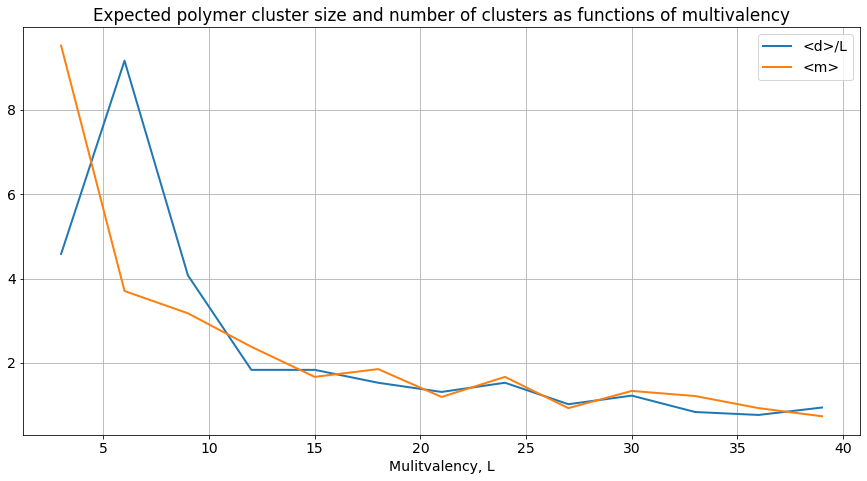

ValueError: x and y must have same first dimension, but have shapes (5,) and (13,)

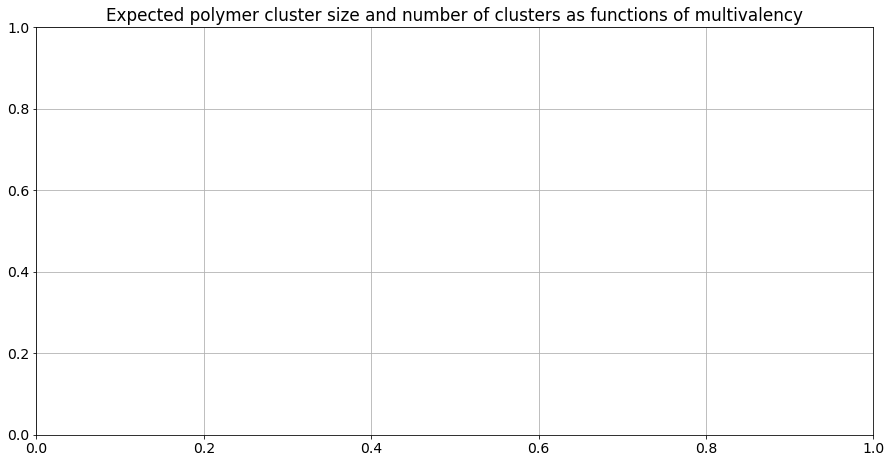

In [33]:
saved_file_1 = np.load('2h_1.npz')
saved_file_2 = np.load('2h_2.npz')


plt.title('Expected polymer cluster size and number of clusters as functions of multivalency') #Gjennomsnittlig cluster-størrelse
plt.plot(L_array, saved_file_1['size_array'], label='<d>/L')
plt.plot(L_array, saved_file_2['size_array'], label='<m>')

# plt.plot(L_array, saved_file_3['size_array'], label='<d>/L 3')
# plt.plot(L_array, size_array_2h_4, label='<d>/L 4')
plt.xlabel('Mulitvalency, L')
plt.legend()
plt.show()

plt.title('Expected polymer cluster size and number of clusters as functions of multivalency') #Gjennomsnittlig antall clustere
plt.plot(N_array, saved_file_1['number_of_clusters'], label='<d>/L')
plt.plot(N_array, saved_file_2['number_of_clusters'], label='<m>')
# plt.plot(L_array, saved_file_3['number_of_clusters'], label='<d>/L 3')
# plt.plot(L_array, size_array_2h_4, label='<d>/L 4')

plt.xlabel('Grid size, N')
plt.legend()
plt.show()

print(f"Hele filen brukte {np.round(time.time() - ULTIMATE_TIME_START, 1)} sekund på å kjøre.") # printer tiden koden brukte

Vi bruker $t_{equil}$ og $n$ som i oppgave 1h) fordi det ga oss ikke altfor lange kjøretider der. Vi ser at $\langle d\rangle/L$ avtar med økende $L$, som jo er å forvente da Vi ser også at den avtar med mer enn $1/3$, som jo er fordi, jo større $L$ jo større sannsynlighet er det for å danne store klynger. Hvis vi flytter uten deformasjon så vil nok grafen avta enda fortere, siden de har vanskeligere for å flytte seg unna hverandre. Vi forventer at det er størst forskjell i $L = 10$ til $L = 20$ siden polymerene ikke er så store, slik at de kan unngå hverandre, eller ha kontakt hele veien, slik at resultatene kan variere. Vil variere mest for små $L$.